### CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

#### 1. Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_line dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


#### 2. Turning name into Tensors

In [3]:
import torch

# Find letter index from all_letters
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for documentation, turn a letter to a <1, n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length * 1 * n_letters>
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#### 3. Creating the Network

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = lineToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8760, -2.8918, -2.9804, -2.8379, -2.9348, -2.8465, -2.9766, -2.8233,
         -2.9332, -2.9477, -2.8183, -2.9203, -2.8157, -2.8791, -2.8853, -2.8639,
         -2.9448, -2.8749]], grad_fn=<LogSoftmaxBackward>)


#### 4. Preparing for the training

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 12)


In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Zappa
category = Italian / line = Scutese
category = Portuguese / line = Romao
category = Polish / line = Wojewodzki
category = Arabic / line = Kassis
category = English / line = Dornan
category = Dutch / line = Tunison
category = Scottish / line = Murphy
category = Polish / line = Zielinski
category = Irish / line = Eoghan


#### 5. Training the network

In [8]:
criterion = nn.NLLLoss()

In [9]:
learning_rate = 0.005

def train(line_tensor, category_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameter' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line , category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every ==0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.6049 Cornish / Spanish ✗ (English)
10000 10% (0m 8s) 1.7586 Shamoun / Arabic ✓
15000 15% (0m 13s) 2.2257 Macdonald / English ✗ (Scottish)
20000 20% (0m 17s) 2.6205 Bishara / Japanese ✗ (Arabic)
25000 25% (0m 21s) 1.4298 Ibanez / Spanish ✓
30000 30% (0m 25s) 1.9253 Steube / Portuguese ✗ (German)
35000 35% (0m 30s) 0.5104 Belesis / Greek ✓
40000 40% (0m 34s) 2.2705 Tron / English ✗ (Vietnamese)
45000 45% (0m 38s) 1.0866 Jo / Korean ✓
50000 50% (0m 43s) 0.1861 Ceallachan / Irish ✓
55000 55% (0m 47s) 0.4073 Rosario / Portuguese ✓
60000 60% (0m 51s) 0.1123 Aconi / Italian ✓
65000 65% (0m 55s) 0.2661 Dam / Vietnamese ✓
70000 70% (1m 0s) 1.3178 Kelly / English ✗ (Irish)
75000 75% (1m 4s) 3.7206 Stein / Chinese ✗ (German)
80000 80% (1m 8s) 0.0179 O'Mooney / Irish ✓
85000 85% (1m 13s) 0.3089 Abatantuono / Italian ✓
90000 90% (1m 17s) 3.7543 Manus / Portuguese ✗ (Irish)
95000 95% (1m 21s) 2.4363 Reyes / Portuguese ✗ (Spanish)
100000 100% (1m 26s) 0.5790 Pasternak / Polish ✓


#### 6. Plotting the results

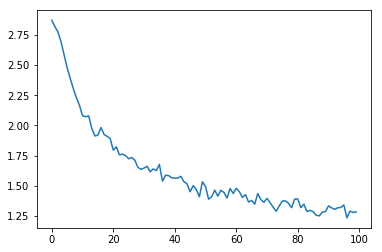

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#### 7. Evaluating the Results

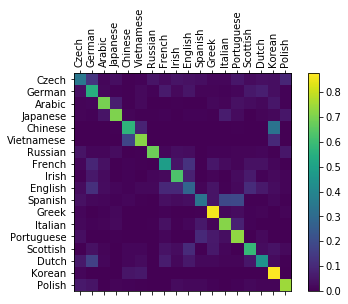

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor =randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

#### 8. Running on User Input

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % (input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.55) Russian
(-1.13) Czech
(-2.96) English

> Jackson
(-0.41) Scottish
(-2.27) English
(-2.34) Russian

> Satoshi
(-0.98) Italian
(-2.00) Japanese
(-2.13) Czech
